#### Advanced Lane Finding Project
##### The goals / steps of this project are the following:
* Compute the camera calibration matrix and distortion coefficients k1 k2 and k3--> using chessboard images.
* Now undistor the images to get the real world dimensions.
* Use the advantages of color space HLS and Sobel operator. Combine the best of both to figure out the lane lines andcreate a thresholded binary image.
* Execute a perspective transform ont hte binary images to get a ("birds-eye view") and make the remeining steps like detect lane line and fit a 2d polynomial easier.
* Detect pixels of the lane line with slipping window method
* Fit a polynomial to calculate the curvature of the lane and to get vehicle position with respect to center.
* Transform the detected lane lines from the warped image (bird eye view) back into a unwarped undistorted imageack into the
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.



In [32]:
#  Initialize the enviraonment conditions for etect lane lines
import numpy as np                 # NumPy
import cv2                         # openCV
import glob                        # Filename pattern matching
import matplotlib.pyplot as plt    # 2D plotting
import matplotlib.image as mpimg
import pickle
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import pickle
import os
from scipy.stats.stats import pearsonr 

left_fitx_old = None
right_fitx_old = None
leftx_base_old = None
rightx_base_old = None

detected = False
leftx_old = None
lefty_old = None
rightx_old = None
righty_old = None

# path for output examples of the several steps
image_path = 'output_images/chessboard_corners/'
image_path_undistorted_images = 'output_images/'

# path from test images
img_dir = 'test_images/'
images = os.listdir(img_dir)

# Interactive plotting in separate window
#%matplotlib qt
# Visualizations will be shown in the notebook
%matplotlib inline

### Helper function

In [33]:
# define pickle to save the distoriton coefficients k1,k1 and k3 'dist' and the camera matrix as 'mtx'
def pickle_dump(mtx, dist):
    # Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
    dist_pickle = {}
    dist_pickle["mtx"] = mtx
    dist_pickle["dist"] = dist
    pickle.dump(dist_pickle, open('wide_dist_pickle.p', 'wb'))
    
def pickle_load():
    # Getting back the camera calibration result:
    with open('wide_dist_pickle.p', 'rb') as f:
        dist_pickle = pickle.load(f)
        return dist_pickle['mtx'], dist_pickle['dist']
    
def draw_and_save_image(path, name, plot=False,save= False):
    # Draw the plot
    if plot:
        plt.imshow(img)
        plt.show()
    # Save to the file
    if save:
        write_name = name + '.jpg'
        cv2.imwrite(str(path) + write_name,img)
    return

# For universal plotting of results
def plot_row2(img1, img2, label_1, label_2, graysc=True):
    # Plot the result (1 row with 2 images)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    f.tight_layout()
    if graysc:
        ax1.imshow(img1, cmap='gray')
    else:
        ax1.imshow(img1)
    ax1.set_title(label_1, fontsize=16)
    ax2.imshow(img2, cmap='gray')
    ax2.set_title(label_2, fontsize=16)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        
            

### Execute the Camera calibration with the calibration images

In [34]:
#Calculate the 3d and 2d points for preparing the camera calibration
def find2D3DCorners():
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
    
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    
    # Make a list of calibration images
    images = glob.glob('camera_cal/calibration*.jpg')
    print('Num of calibration images: {0}'.format(len(images)))
    print('Watching the images in the:',path)
    
    # Step through the list and search for chessboard corners
    for img_id, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            # draw and save depending on given arguments and pathes
            draw_and_save_image(image_path, 'chesboard_corners'+ str(img_id),plot=True,save=True)
            
    return objpoints, imgpoints

In [ ]:
# Calibrate the camero using the find2D3DCorners and cv2.calibrateCamera
# returns the mtx=camera matrix for tranfer 3d into 2d,dis=distortion coefficients
# In this project we will ignore the rvecs=rotation Vectors, tvecs=translationVectors
# This step have to be done only once in the project for getting mtx and dist of the calibration images
def calibrate_camera(img):
    img_size = (img.shape[1], img.shape[0])
    # Claculate the 2d and 3d object point 
    objpoints, imgpoints = find2D3DCorners()
    # Calculate the camera matrix dist=distortion coefficients
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    # Save the camera ntx and dist to pickle data set
    pickle_dump(mtx, dist)
    print('CALIBRATION DONE')
    return mtx, dist

# execute calibration step
mtx, dist = calibrate_camera(img)


### Color Threshold and Gradient Threshold

#### Gradient Threshold Methods with

In [35]:
# Apply Sobel directional gradient and apply gradient threshold
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Take s-channel of HLS color space
    img_trans = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    img_trans = img_trans[:,:,2]
    # Calculate the derivative. That depends on argument orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(img_trans, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient == 'y':
        sobel = cv2.Sobel(img_trans, cv2.CV_64F, 0, 1, ksize=sobel_kernel) 
    # Calc absolute gradient
    abs_sobel = np.absolute(sobel)
    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    # Create a mask of 1's where the scaled gradient magnitude 
    binary_output = np.zeros_like(scaled_sobel)
    # is > thresh_min and < thresh_max
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # Return mask as binary_output image
    return binary_output

# Define a function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to HLS
    img_trans = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # Take the s channel as reference
    img_trans = img_trans[:,:,2]
    # Take the gradient in x and y separately
    sobel_x = cv2.Sobel(img_trans, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(img_trans, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobel_x**2 + sobel_y**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    # Return masked image as the binary_output image
    return binary_output

# Calculate gradient direction and apply threshold
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Convert to HLS
    img_trans = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # Take the s channel as reference
    img_trans = img_trans[:,:,2]
    # Calculate the x and y gradients
    sobel_x = cv2.Sobel(img_trans, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(img_trans, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobel_y), np.absolute(sobel_x))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    # Return this mask as binary_output image
    return binary_output

In [36]:
def combinedGradientThresholds(img, do_plot=False):
    # Gaussian Blur
    kernel_size = 5
    img = cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)
    # Sobel kernel size (choose a larger odd number to smooth gradient measurements)
    ksize = 7
    # Apply Sobel on x-axis
    grad_x_binary = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(10, 255))
    # Apply Sobel on y-axis
    grad_y_binary = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=(60, 255))
    # Apply Sobel x and y, compute the magnitude of the gradient and apply a threshold
    mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(40, 255))
    # Apply Sobel x and y, computes the direction of the gradient and apply a threshold
    dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=(0.65, 1.05))
    
    # Combine the thresholds
    combined = np.zeros_like(dir_binary)
    combined[((grad_x_binary == 1) & (grad_y_binary == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    # Return the best of Gradient Threshold
    return combined

#### Color Threshold Methods

In [37]:
# combine the best out of two worös color and gradient threshold methods
def combinedColorSpaceThresholds(img, thresh=(0, 255)):
    #img = np.copy(img)
    # Convert to HLS color space and separate the S channel
    #hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= thresh[0]) & (s_channel <= thresh[1])] = 1
    
    # mapping for generalization for later mixed up color space solution
    colorBinary = s_binary 
        
    return colorBinary

#### Combine Color Threshold and Gradient Threshold

In [38]:
def combineColorAndGradientThresholds(image):
    # Perform Sobel operations and combine thresholds
    combinedGradientSobel = combinedGradientThresholds(image)
    plot_row2(image, combinedGradientSobel, 'undistorted' ,'Sobel Combined Gradients', graysc=True)
    
    # Threshold color channel
    combinedColorThresholds = combinedColorSpaceThresholds(image, thresh=(160, 255))
    plot_row2(image, combinedColorThresholds, 'undistorted' ,'Color Threshold', graysc=True)
    
    # Combine color and gradient thresholds
    combinedThresholdsBinaryImage = np.zeros_like(combinedColorThresholds)
    combinedThresholdsBinaryImage[(combinedGradientSobel == 1) | (combinedColorThresholds == 1)] = 1
    plot_row2(image, combinedThresholdsBinaryImage, 'undistorted' ,'Color and Sobel Combined Threshold', graysc=True)

    
    
    return combinedThresholdsBinaryImage

In [39]:
# Practical approach to define src and dst point in the original and output image
def calcSrcAndDstPoints(img):
    
    #another possibility to choose src and dst
    #w,h = 1280,720`
    #x,y = 0.5*w, 0.8*h
    #src = np.float32([[200./1280*w,720./720*h],
    #              [453./1280*w,547./720*h],
    #              [835./1280*w,547./720*h],
    #              [1100./1280*w,720./720*h]])
    #dst = np.float32([[(w-x)/2.,h],
    #              [(w-x)/2.,0.82*h],
    #              [(w+x)/2.,0.82*h],
    #              [(w+x)/2.,h]])
    ## Define 4 source points
    src = np.float32([[180, img.shape[0]], [575, 460], 
                      [705, 460], [1150, img.shape[0]]])
    # Define 4 destination points
    dst = np.float32([[320, img.shape[0]], [320, 0], 
                      [960, 0], [960, img.shape[0]]])
    
    return src,dst

In [40]:
# Implement Sliding Windows and Fit a Polynomial
def slidingWindowMethod (binary_warped, leftx_base, rightx_base):
    
    # Assuming you have created a warped binary image called "binary_warped"
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255    
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    global leftx_old
    global lefty_old

    global rightx_old
    global righty_old
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    if (len(leftx) < 1500):
        leftx = leftx_old 
        lefty = lefty_old
        detected = False
    else:
        leftx_old = leftx
        lefty_old = lefty
    if (len(rightx) < 1500):
        rightx = rightx_old
        righty = righty_old
        detected = False
    else:
        rightx_old = rightx
        righty_old = righty
    
    left_fit, right_fit = polynomFit2nd(lefty, leftx, righty, rightx)
    left_fitx, right_fitx, ploty = genrateValuesXYforPlot(binary_warped,left_fit,right_fit)
       
    left_fitx, right_fitx = sanityCheck(left_fitx, right_fitx)

    
    
    return out_img,ploty,leftx, lefty, rightx, righty, left_fit, right_fit, left_fitx, right_fitx,

In [41]:
def polynomFit2nd(lefty, leftx, righty, rightx):
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit

In [42]:
def genrateValuesXYforPlot(binary_warped,left_fit,right_fit):
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx,right_fitx,ploty

In [43]:
# Applies an image mask
# Only keeps the region of the image defined by the polygon formed from `vertices`.
# The rest of the image is set to black.
def region_of_interest(img, vertices):
    # Defining a blank mask to start with
    mask = np.zeros_like(img)
    ignore_mask_color = 255
    # Fill pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    # Return the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [44]:
def sanity_check(left_fit, right_fit, minSlope, maxSlope):
    #Performs a sanity check on the lanes
    #Check 1: check if left and right fits exists
    #Check 2: Calculates the tangent between left and right in two points, and check if it is in a reasonable threshold
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    if len(left_fit) ==0 or len(right_fit) == 0:
        status = False
        d0=0
        d1=0
        #Previous fitlines routine returns empty list to them if not finds
    else:
        #Difference of slope
        L_0 = 2*left_fit[0]*460+left_fit[1]
        R_0 = 2*right_fit[0]*460+right_fit[1]
        d0 =  np.abs(L_0-R_0)

        L_1 = 2*left_fit[0]*720+left_fit[1]
        R_1 = 2*right_fit[0]*720+right_fit[1]
        d1 =  np.abs(L_1-R_1)
        
        if d0>= minSlope and d0<= maxSlope and d1>= minSlope and d1<= maxSlope:
            status = True
        else:
            status = False
            
    return(status, d0, d1)

In [45]:
def sanityCheck(left_fitx,right_fitx,threshold=0.85):
    global left_fitx_old
    global right_fitx_old
    
    if (left_fitx_old == None):
        left_fitx_old = left_fitx
        
    if (right_fitx_old == None):
        right_fitx_old = right_fitx
            
    ret_left = pearsonr (left_fitx_old, left_fitx)
    ret_right = pearsonr (right_fitx_old, right_fitx)
    
    if (ret_left[0] > threshold):
        left_fitx_old = left_fitx   
    else:
        left_fitx = left_fitx_old
    
    if (ret_right[0] > threshold):
        right_fitx_old = right_fitx
    else:
        right_fitx = right_fitx_old
        
    return left_fitx, right_fitx

In [112]:
  
def main(img):
    # Load calibration data generated in calibrate_camera
    mtx, dist = pickle_load()
    # Calculate the undistorted image
    image_undistored = cv2.undistort(img, mtx, dist, None, mtx)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(image_undistored)
    ax2.set_title('Undistorted Image', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
    #Calculate combined binaryImage based on a mix of both    
    # using cv2.findChessboardCorners
    src, dst = calcSrcAndDstPoints(image_undistored)
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    
    # Warp the image using OpenCV warpPerspective()
    img_size = (image_undistored.shape[1], image_undistored.shape[0])
    warped = cv2.warpPerspective(image_undistored, M, img_size, flags=cv2.INTER_LINEAR) 
    
    # combinedColorThresholds and combinedSobelGradient threshold methods
    binary_warped = combineColorAndGradientThresholds(warped)    # define source_img and destination_img point for preparing the perspective transform
    
    i=1
    
    f, (ax1,ax2) = plt.subplots(1, 2, figsize = (20,10))
    ax1.imshow(warped)
    ax1.set_title('Warped', fontsize = 15)
    ax2.imshow(binary_warped, cmap="gray")
    ax2.set_title('Binary Image', fontsize = 15)    
    # Define image mask (polygon of interest)
    binaryWarpedImageShape = binary_warped.shape
    vertices = np.array([[(200, binaryWarpedImageShape[0]), (200, 0), (binaryWarpedImageShape[1] - 200, 0), 
                      (binaryWarpedImageShape[1]-200, binaryWarpedImageShape[0])]], dtype=np.int32)
    binaryWarpedMaskedImage = region_of_interest(binary_warped, vertices)
    
    
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    mid_of_lane = leftx_base + (rightx_base - leftx_base) / 2
    car_pos = binary_warped.shape[1] / 2
    deviation = int(abs(mid_of_lane - car_pos) * (3.7 / 700) * 100)  

    
    global leftx_base_old
    global rightx_base_old
    #print("before", abs(leftx_base - rightx_base))
    
    if (leftx_base_old == None):
        leftx_base_old = leftx_base
        
    if (rightx_base_old == None):
        rightx_base_old = rightx_base

    if (abs(leftx_base - rightx_base) < 250) & (abs(leftx_base - rightx_base) > 160):
        leftx_base_old = leftx_base
        rightx_base_old = rightx_base
    else:
        leftx_base = leftx_base_old
        rightx_base = rightx_base_old
    
    out_img,ploty,leftx, lefty, rightx, righty, left_fit, right_fit, left_fitx, right_fitx, = slidingWindowMethod(binaryWarpedMaskedImage,leftx_base, rightx_base)
    
        
    f, (ax1,ax2) = plt.subplots(1, 2, figsize = (20,10))
    ax1.imshow(out_img)
    ax1.set_title('Sliding Windows', fontsize = 15)
    ax2.imshow(out_img, cmap="gray")
    ax2.set_title('Binary Image', fontsize = 15)    

   
    #leftx, lefty, rightx, righty = lookAheadFilter(left_fit, right_fit, binaryWarpedMaskedImage)
    #left_fit, right_fit = polynomFit2nd(lefty, leftx, righty, rightx)
    #left_fitx, right_fitx, ploty = genrateValuesXYforPlot(binaryWarpedMaskedImage,left_fit,right_fit)
    #out_img = np.dstack((binaryWarpedMaskedImage, binaryWarpedMaskedImage, binaryWarpedMaskedImage))*255    
    
    
    
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    left_curveradPixelSpace, right_curveradPixelSpace = getRadiusPixelSpace(left_fit,right_fit,y_eval)
    
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    

    
    left_curveradMeter, right_curveradMeter = convertRadiusIntoMeter(ploty,y_eval,leftx, lefty, rightx, righty)


    #Compute the inverse perspective transform to unwarped the image
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    finalOutputImage = drawPolynomialsBackIntoOriginalImage(binaryWarpedMaskedImage,image_undistored, out_img, left_fitx, right_fitx, left_curveradMeter, right_curveradMeter,deviation, ploty, Minv)
    
    return finalOutputImage
    

In [ ]:
#Test Image Pipeline
for image in images:
    print(img_dir + image)
    img = mpimg.imread(img_dir + image)
    result = main(img)
    plt.imshow(result)
    #plt.imsave(image + "_found.png", result)
    plt.show()
    


1672.75600392 m 167.53931412 m


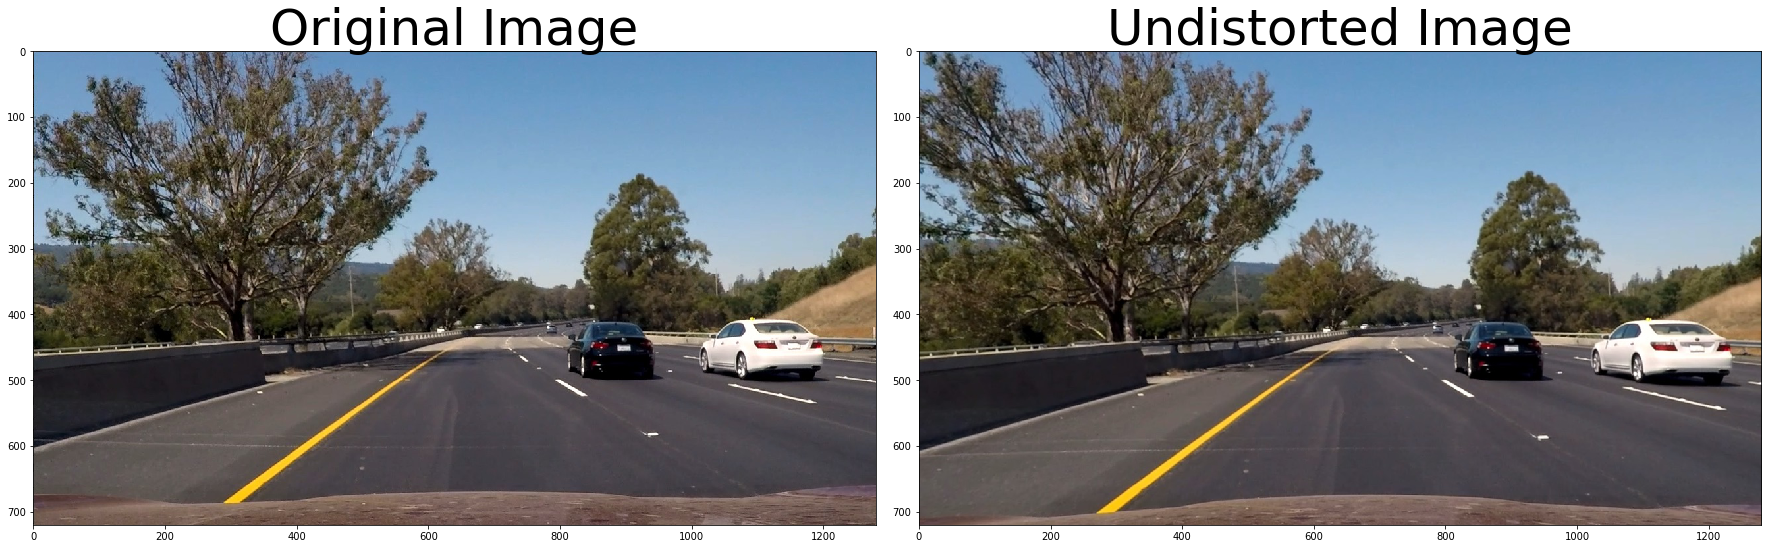

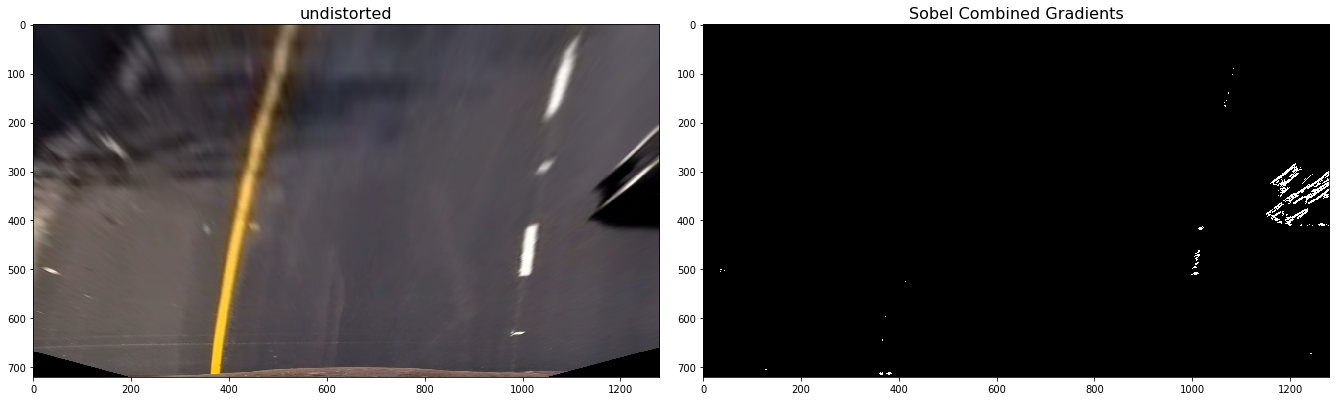

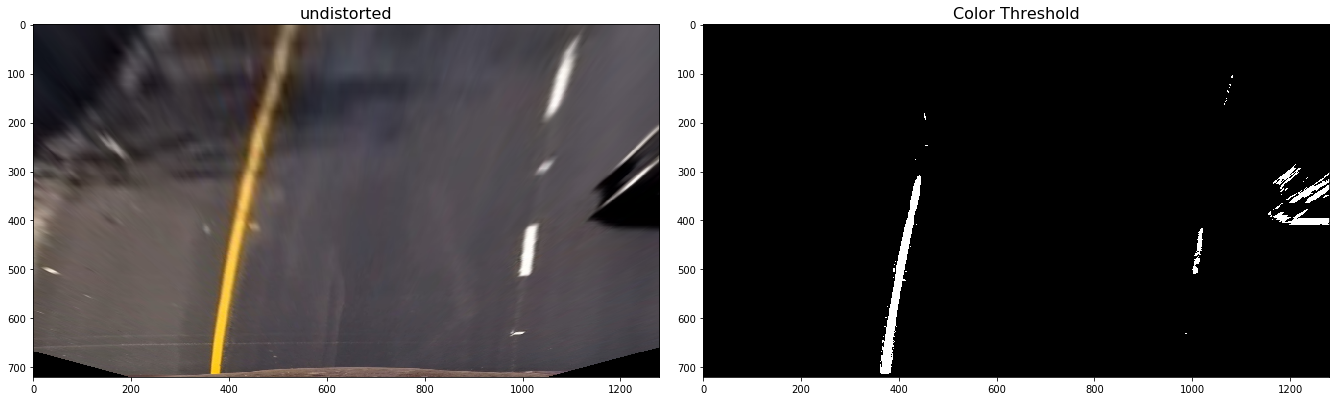

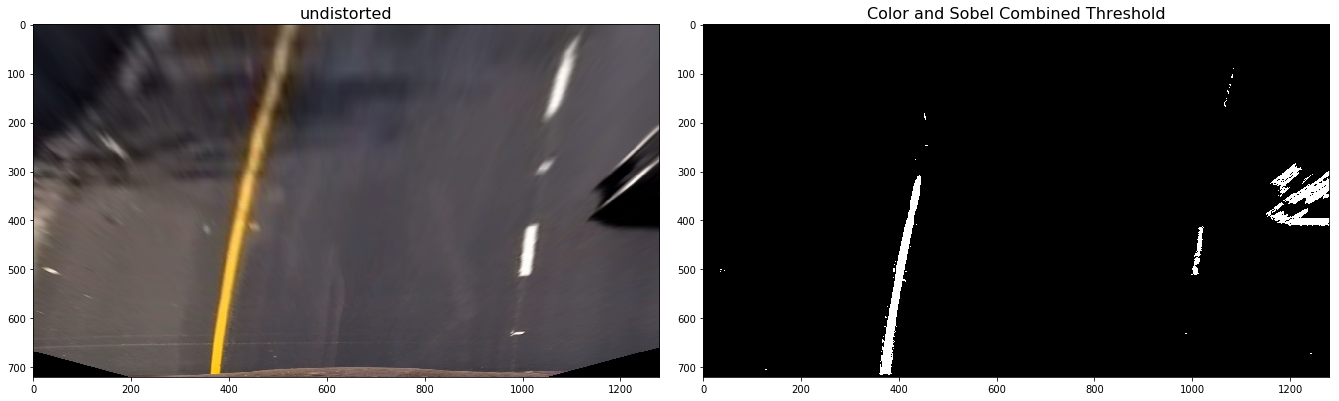

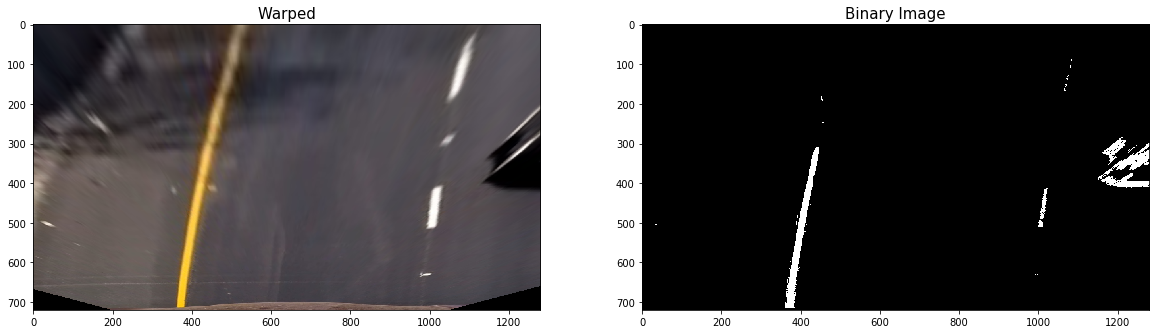

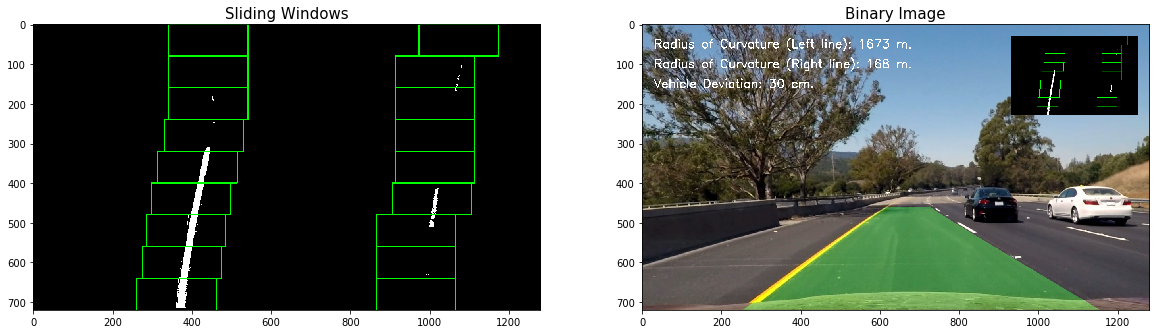

In [117]:
# MONITOR (FOR TESTING IMAGE PIPELINE)
image = mpimg.imread('test_images/test6.jpg')
result = main(image)
plt.imshow(result)
#plt.imsave(image + "_found.png", result)
#plt.show()

In [118]:
#left_line = Line()
#right_line = Line()
output_video = 'first_draft.mp4'
clip1 = VideoFileClip("project_video.mp4")
video_clip = clip1.fl_image(main)
%time video_clip.write_videofile(output_video, audio=False)

#white_output = 'first_draft.mp4'
#clip1 = VideoFileClip("project_video.mp4")
#white_clip = clip1.fl_image(main) #NOTE: this function expects color images!!
#time white_clip.write_videofile(white_output, audio=False)

844.150063516 m 167.53931412 m
[MoviePy] >>>> Building video first_draft.mp4
[MoviePy] Writing video first_draft.mp4


  0%|          | 0/1261 [00:00<?, ?it/s]

844.150063516 m 167.53931412 m


  0%|          | 1/1261 [00:01<22:06,  1.05s/it]

798.207010337 m 167.53931412 m


  0%|          | 2/1261 [00:02<22:10,  1.06s/it]

769.457276795 m 167.53931412 m


  0%|          | 3/1261 [00:03<22:35,  1.08s/it]

731.787095942 m 1137.33644165 m


  0%|          | 4/1261 [00:04<21:33,  1.03s/it]

695.549092188 m 1137.33644165 m


  0%|          | 5/1261 [00:05<22:14,  1.06s/it]

688.56652457 m 1137.33644165 m


  0%|          | 6/1261 [00:06<21:35,  1.03s/it]

726.201269606 m 1137.33644165 m


  1%|          | 7/1261 [00:07<21:07,  1.01s/it]

729.528991305 m 1137.33644165 m


  1%|          | 8/1261 [00:08<22:10,  1.06s/it]

749.548228732 m 1137.33644165 m


  1%|          | 9/1261 [00:09<21:57,  1.05s/it]

762.768554182 m 1137.33644165 m


  1%|          | 10/1261 [00:10<22:40,  1.09s/it]

788.22696699 m 1137.33644165 m


  1%|          | 11/1261 [00:11<23:32,  1.13s/it]

872.676194724 m 1137.33644165 m


  1%|          | 12/1261 [00:12<22:17,  1.07s/it]

919.975808321 m 1137.33644165 m


  1%|          | 13/1261 [00:13<21:38,  1.04s/it]

988.460164934 m 1137.33644165 m


  1%|          | 14/1261 [00:14<20:59,  1.01s/it]

1042.74353751 m 1137.33644165 m


  1%|          | 15/1261 [00:16<23:21,  1.13s/it]

1091.4247503 m 1137.33644165 m


  1%|▏         | 16/1261 [00:17<22:55,  1.10s/it]

1046.69735387 m 1137.33644165 m


  1%|▏         | 17/1261 [00:18<22:55,  1.11s/it]

1061.12495551 m 1137.33644165 m


  1%|▏         | 18/1261 [00:19<22:33,  1.09s/it]

1136.01635485 m 1137.33644165 m


  2%|▏         | 19/1261 [00:20<23:01,  1.11s/it]

1248.77530063 m 1137.33644165 m


  2%|▏         | 20/1261 [00:21<25:31,  1.23s/it]

1362.06064699 m 1137.33644165 m


  2%|▏         | 21/1261 [00:22<24:06,  1.17s/it]

1490.39511045 m 1137.33644165 m


  2%|▏         | 22/1261 [00:23<23:11,  1.12s/it]

1524.76985668 m 1137.33644165 m


  2%|▏         | 23/1261 [00:24<22:02,  1.07s/it]

1388.71267056 m 1137.33644165 m


  2%|▏         | 24/1261 [00:25<21:38,  1.05s/it]

1270.42673446 m 1137.33644165 m


  2%|▏         | 25/1261 [00:26<21:22,  1.04s/it]

1305.01041955 m 1137.33644165 m


  2%|▏         | 26/1261 [00:28<22:14,  1.08s/it]

1248.44723581 m 1137.33644165 m


  2%|▏         | 27/1261 [00:29<26:14,  1.28s/it]

1323.85843283 m 1137.33644165 m


  2%|▏         | 28/1261 [00:30<24:07,  1.17s/it]

1170.92741228 m 1137.33644165 m


  2%|▏         | 29/1261 [00:31<23:05,  1.12s/it]

928.739256193 m 1137.33644165 m


  2%|▏         | 30/1261 [00:32<22:20,  1.09s/it]

844.288777745 m 1137.33644165 m


  2%|▏         | 31/1261 [00:33<21:29,  1.05s/it]

754.250836736 m 1137.33644165 m


  3%|▎         | 32/1261 [00:34<21:14,  1.04s/it]

757.295177742 m 1137.33644165 m


  3%|▎         | 33/1261 [00:35<20:36,  1.01s/it]

714.860453856 m 1137.33644165 m


  3%|▎         | 34/1261 [00:37<25:21,  1.24s/it]

687.114362786 m 1137.33644165 m


  3%|▎         | 35/1261 [00:38<24:00,  1.18s/it]

665.787013616 m 1137.33644165 m


  3%|▎         | 36/1261 [00:39<23:18,  1.14s/it]

651.737817896 m 1137.33644165 m


  3%|▎         | 37/1261 [00:40<22:44,  1.11s/it]

617.358652888 m 1137.33644165 m


  3%|▎         | 38/1261 [00:41<22:01,  1.08s/it]

603.940948692 m 1137.33644165 m


  3%|▎         | 39/1261 [00:42<21:45,  1.07s/it]

602.985588772 m 1137.33644165 m


  3%|▎         | 40/1261 [00:43<21:38,  1.06s/it]

603.170713465 m 1137.33644165 m


  3%|▎         | 41/1261 [00:44<21:16,  1.05s/it]

603.522652935 m 1137.33644165 m


  3%|▎         | 42/1261 [00:45<21:03,  1.04s/it]

567.021061707 m 1137.33644165 m


  3%|▎         | 43/1261 [00:47<27:49,  1.37s/it]

587.436891241 m 1137.33644165 m


  3%|▎         | 44/1261 [00:48<25:38,  1.26s/it]

597.574150558 m 1137.33644165 m


  4%|▎         | 45/1261 [00:49<23:58,  1.18s/it]

605.086010803 m 1137.33644165 m


  4%|▎         | 46/1261 [00:50<22:55,  1.13s/it]

629.407811569 m 1137.33644165 m


  4%|▎         | 47/1261 [00:51<21:50,  1.08s/it]

642.163483595 m 1137.33644165 m


  4%|▍         | 48/1261 [00:52<21:57,  1.09s/it]

691.168845392 m 1137.33644165 m


  4%|▍         | 49/1261 [00:53<21:29,  1.06s/it]

737.495551935 m 1137.33644165 m


  4%|▍         | 50/1261 [00:55<21:30,  1.07s/it]

797.123930467 m 1137.33644165 m


  4%|▍         | 51/1261 [00:56<21:20,  1.06s/it]

871.476672485 m 1137.33644165 m


  4%|▍         | 52/1261 [00:57<21:41,  1.08s/it]

935.783644733 m 1137.33644165 m


  4%|▍         | 53/1261 [00:58<21:23,  1.06s/it]

1033.20154488 m 1137.33644165 m


  4%|▍         | 54/1261 [00:59<21:51,  1.09s/it]

1048.26382814 m 1137.33644165 m


  4%|▍         | 55/1261 [01:01<30:40,  1.53s/it]

1174.96455582 m 1137.33644165 m


  4%|▍         | 56/1261 [01:03<28:20,  1.41s/it]

1246.4395554 m 1137.33644165 m


  5%|▍         | 57/1261 [01:04<25:45,  1.28s/it]

1305.00435287 m 1137.33644165 m


  5%|▍         | 58/1261 [01:05<24:52,  1.24s/it]

1242.20458256 m 1137.33644165 m


  5%|▍         | 59/1261 [01:06<23:45,  1.19s/it]

1171.6968829 m 1137.33644165 m


  5%|▍         | 60/1261 [01:07<23:45,  1.19s/it]

1087.17270817 m 1137.33644165 m


  5%|▍         | 61/1261 [01:08<23:54,  1.20s/it]

1034.98900431 m 1137.33644165 m


  5%|▍         | 62/1261 [01:09<23:26,  1.17s/it]

1042.42946061 m 1137.33644165 m


  5%|▍         | 63/1261 [01:10<23:16,  1.17s/it]

980.658897453 m 1137.33644165 m


  5%|▌         | 64/1261 [01:12<23:07,  1.16s/it]

982.9080357 m 1137.33644165 m


  5%|▌         | 65/1261 [01:13<25:04,  1.26s/it]

960.633236429 m 1137.33644165 m


  5%|▌         | 66/1261 [01:14<24:11,  1.21s/it]

978.256983401 m 1137.33644165 m


  5%|▌         | 67/1261 [01:15<23:26,  1.18s/it]

836.124477893 m 1137.33644165 m


  5%|▌         | 68/1261 [01:17<24:06,  1.21s/it]

798.542483158 m 1137.33644165 m


  5%|▌         | 69/1261 [01:19<33:18,  1.68s/it]

858.874015503 m 1137.33644165 m


  6%|▌         | 70/1261 [01:20<29:03,  1.46s/it]

850.913051352 m 1137.33644165 m


  6%|▌         | 71/1261 [01:21<25:51,  1.30s/it]

904.274126524 m 1137.33644165 m


  6%|▌         | 72/1261 [01:22<23:55,  1.21s/it]

970.185168319 m 1137.33644165 m


  6%|▌         | 73/1261 [01:23<22:46,  1.15s/it]

1107.95903377 m 1137.33644165 m


  6%|▌         | 74/1261 [01:24<22:15,  1.12s/it]

1255.19256312 m 1137.33644165 m


  6%|▌         | 75/1261 [01:25<21:31,  1.09s/it]

1428.44725818 m 1137.33644165 m


  6%|▌         | 76/1261 [01:26<21:03,  1.07s/it]

1813.22272931 m 1137.33644165 m


  6%|▌         | 77/1261 [01:27<20:41,  1.05s/it]

2323.14262163 m 1137.33644165 m


  6%|▌         | 78/1261 [01:29<21:50,  1.11s/it]

2856.61365573 m 1137.33644165 m


  6%|▋         | 79/1261 [01:30<21:38,  1.10s/it]

2519.56720935 m 1137.33644165 m


  6%|▋         | 80/1261 [01:31<21:08,  1.07s/it]

2546.716412 m 1137.33644165 m


  6%|▋         | 81/1261 [01:32<21:01,  1.07s/it]

2559.44271002 m 1137.33644165 m


  7%|▋         | 82/1261 [01:33<20:57,  1.07s/it]

2198.57264361 m 1137.33644165 m


  7%|▋         | 83/1261 [01:34<21:45,  1.11s/it]

2308.48376821 m 1137.33644165 m


  7%|▋         | 84/1261 [01:35<21:38,  1.10s/it]

1962.79495834 m 1137.33644165 m


  7%|▋         | 85/1261 [01:36<21:11,  1.08s/it]

1560.54713584 m 1137.33644165 m


  7%|▋         | 86/1261 [01:39<32:00,  1.63s/it]

1264.67798076 m 1137.33644165 m


  7%|▋         | 87/1261 [01:40<28:32,  1.46s/it]

1101.06705361 m 1137.33644165 m


  7%|▋         | 88/1261 [01:41<26:21,  1.35s/it]

973.575663073 m 1137.33644165 m


  7%|▋         | 89/1261 [01:42<24:18,  1.24s/it]

900.4667279 m 1137.33644165 m


  7%|▋         | 90/1261 [01:43<22:42,  1.16s/it]

944.164986224 m 774.156836805 m


  7%|▋         | 91/1261 [01:45<25:05,  1.29s/it]

967.255379318 m 775.363980612 m


  7%|▋         | 92/1261 [01:46<26:57,  1.38s/it]

832.877689797 m 775.363980612 m


  7%|▋         | 93/1261 [01:47<25:23,  1.30s/it]

802.916896235 m 775.363980612 m


  7%|▋         | 94/1261 [01:49<24:29,  1.26s/it]

816.373849389 m 775.363980612 m


  8%|▊         | 95/1261 [01:50<23:26,  1.21s/it]

806.256737834 m 775.363980612 m


  8%|▊         | 96/1261 [01:51<22:20,  1.15s/it]

816.35089983 m 775.363980612 m


  8%|▊         | 97/1261 [01:52<24:13,  1.25s/it]

843.822443653 m 775.363980612 m


  8%|▊         | 98/1261 [01:53<22:46,  1.17s/it]

840.415038915 m 775.363980612 m


  8%|▊         | 99/1261 [01:54<21:54,  1.13s/it]

885.554082996 m 775.363980612 m


  8%|▊         | 100/1261 [01:55<22:11,  1.15s/it]

910.183067093 m 775.363980612 m


  8%|▊         | 101/1261 [01:57<22:11,  1.15s/it]

921.885181907 m 775.363980612 m


  8%|▊         | 102/1261 [01:58<22:06,  1.14s/it]

944.642885343 m 775.363980612 m


  8%|▊         | 103/1261 [01:59<23:24,  1.21s/it]

980.712933044 m 775.363980612 m


  8%|▊         | 104/1261 [02:00<22:00,  1.14s/it]

1059.04673503 m 775.363980612 m


  8%|▊         | 105/1261 [02:01<21:29,  1.12s/it]

983.85694256 m 775.363980612 m


  8%|▊         | 106/1261 [02:02<21:16,  1.10s/it]

993.623440413 m 775.363980612 m


  8%|▊         | 107/1261 [02:06<37:30,  1.95s/it]

897.495914445 m 775.363980612 m


  9%|▊         | 108/1261 [02:07<32:33,  1.69s/it]

874.218213426 m 775.363980612 m


  9%|▊         | 109/1261 [02:08<28:37,  1.49s/it]

858.264139839 m 775.363980612 m


  9%|▊         | 110/1261 [02:09<26:13,  1.37s/it]

832.491257789 m 775.363980612 m


  9%|▉         | 111/1261 [02:10<25:17,  1.32s/it]

870.341769986 m 775.363980612 m


  9%|▉         | 112/1261 [02:12<24:11,  1.26s/it]

822.930388763 m 775.363980612 m


  9%|▉         | 113/1261 [02:13<24:41,  1.29s/it]

818.908576828 m 775.363980612 m


  9%|▉         | 114/1261 [02:14<23:34,  1.23s/it]

774.807908426 m 775.363980612 m


  9%|▉         | 115/1261 [02:15<23:00,  1.20s/it]

775.111939943 m 775.363980612 m


  9%|▉         | 116/1261 [02:16<22:49,  1.20s/it]

772.534067466 m 775.363980612 m


  9%|▉         | 117/1261 [02:18<22:52,  1.20s/it]

718.332256254 m 775.363980612 m


  9%|▉         | 118/1261 [02:19<22:03,  1.16s/it]

712.533733285 m 775.363980612 m


  9%|▉         | 119/1261 [02:20<21:39,  1.14s/it]

678.681934137 m 775.363980612 m


 10%|▉         | 120/1261 [02:21<20:36,  1.08s/it]

681.87013684 m 775.363980612 m


 10%|▉         | 121/1261 [02:22<20:13,  1.06s/it]

675.671566502 m 775.363980612 m


 10%|▉         | 122/1261 [02:23<20:17,  1.07s/it]

652.857834823 m 775.363980612 m


 10%|▉         | 123/1261 [02:24<19:36,  1.03s/it]

663.209033416 m 775.363980612 m


 10%|▉         | 124/1261 [02:25<19:21,  1.02s/it]

667.48530381 m 775.363980612 m


 10%|▉         | 125/1261 [02:26<18:55,  1.00it/s]

713.699286776 m 775.363980612 m


 10%|▉         | 126/1261 [02:27<19:31,  1.03s/it]

708.182105675 m 775.363980612 m


 10%|█         | 127/1261 [02:28<19:57,  1.06s/it]

740.130757595 m 775.363980612 m


 10%|█         | 128/1261 [02:29<19:36,  1.04s/it]

733.959857098 m 775.363980612 m


 10%|█         | 129/1261 [02:30<19:12,  1.02s/it]

736.230861705 m 775.363980612 m


 10%|█         | 130/1261 [02:31<19:14,  1.02s/it]

747.731931056 m 775.363980612 m


 10%|█         | 131/1261 [02:32<18:57,  1.01s/it]

755.645411499 m 775.363980612 m


 10%|█         | 132/1261 [02:33<19:11,  1.02s/it]

794.049642115 m 775.363980612 m


 11%|█         | 133/1261 [02:37<35:55,  1.91s/it]

814.789242407 m 775.363980612 m


 11%|█         | 134/1261 [02:38<30:56,  1.65s/it]

850.60415294 m 775.363980612 m


 11%|█         | 135/1261 [02:39<27:19,  1.46s/it]

886.548863405 m 775.363980612 m


 11%|█         | 136/1261 [02:40<24:30,  1.31s/it]

913.769443823 m 775.363980612 m


 11%|█         | 137/1261 [02:41<22:36,  1.21s/it]

965.778175318 m 775.363980612 m


 11%|█         | 138/1261 [02:42<21:16,  1.14s/it]

980.937829426 m 775.363980612 m


 11%|█         | 139/1261 [02:43<21:12,  1.13s/it]

1057.99304246 m 775.363980612 m


 11%|█         | 140/1261 [02:44<20:22,  1.09s/it]

1049.66119028 m 775.363980612 m


 11%|█         | 141/1261 [02:45<19:51,  1.06s/it]

1111.77747036 m 775.363980612 m


 11%|█▏        | 142/1261 [02:46<19:59,  1.07s/it]

949.381198981 m 775.363980612 m


 11%|█▏        | 143/1261 [02:47<20:00,  1.07s/it]

931.109880544 m 775.363980612 m


 11%|█▏        | 144/1261 [02:48<19:16,  1.04s/it]

935.368175974 m 775.363980612 m


 11%|█▏        | 145/1261 [02:49<18:58,  1.02s/it]

948.419881643 m 775.363980612 m


 12%|█▏        | 146/1261 [02:50<18:35,  1.00s/it]

976.738130126 m 775.363980612 m


 12%|█▏        | 147/1261 [02:51<18:46,  1.01s/it]

935.979228708 m 775.363980612 m


 12%|█▏        | 148/1261 [02:52<18:41,  1.01s/it]

973.839493667 m 775.363980612 m


 12%|█▏        | 149/1261 [02:53<18:50,  1.02s/it]

1050.64358144 m 775.363980612 m


 12%|█▏        | 150/1261 [02:54<18:40,  1.01s/it]

1090.66411196 m 775.363980612 m


 12%|█▏        | 151/1261 [02:55<18:55,  1.02s/it]

1163.44329626 m 775.363980612 m


 12%|█▏        | 152/1261 [02:56<18:34,  1.00s/it]

1179.76108451 m 775.363980612 m


 12%|█▏        | 153/1261 [02:57<19:39,  1.06s/it]

1250.85013891 m 775.363980612 m


 12%|█▏        | 154/1261 [02:58<19:53,  1.08s/it]

1128.95880084 m 775.363980612 m


 12%|█▏        | 155/1261 [03:00<19:49,  1.08s/it]

1111.6469161 m 775.363980612 m


 12%|█▏        | 156/1261 [03:00<19:11,  1.04s/it]

1069.71743868 m 775.363980612 m


 12%|█▏        | 157/1261 [03:02<19:37,  1.07s/it]

955.658643205 m 775.363980612 m


 13%|█▎        | 158/1261 [03:03<19:13,  1.05s/it]

953.696410095 m 775.363980612 m


 13%|█▎        | 159/1261 [03:04<19:11,  1.05s/it]

898.738741563 m 775.363980612 m


 13%|█▎        | 160/1261 [03:05<18:44,  1.02s/it]

876.521800808 m 775.363980612 m


 13%|█▎        | 161/1261 [03:06<19:23,  1.06s/it]

874.862370014 m 775.363980612 m


 13%|█▎        | 162/1261 [03:07<18:59,  1.04s/it]

889.760798003 m 775.363980612 m


 13%|█▎        | 163/1261 [03:08<19:56,  1.09s/it]

857.758750717 m 775.363980612 m


 13%|█▎        | 164/1261 [03:09<19:57,  1.09s/it]

832.845216367 m 775.363980612 m


 13%|█▎        | 165/1261 [03:14<39:56,  2.19s/it]

876.024203131 m 775.363980612 m


 13%|█▎        | 166/1261 [03:15<33:28,  1.83s/it]

812.699158696 m 775.363980612 m


 13%|█▎        | 167/1261 [03:16<29:09,  1.60s/it]

887.561103905 m 775.363980612 m


 13%|█▎        | 168/1261 [03:17<25:55,  1.42s/it]

932.036276854 m 775.363980612 m


 13%|█▎        | 169/1261 [03:18<23:44,  1.30s/it]

982.014834413 m 775.363980612 m


 13%|█▎        | 170/1261 [03:19<22:10,  1.22s/it]

1032.11798868 m 775.363980612 m


 14%|█▎        | 171/1261 [03:20<20:43,  1.14s/it]

1065.47912774 m 775.363980612 m


 14%|█▎        | 172/1261 [03:21<19:57,  1.10s/it]

1097.53780384 m 775.363980612 m


 14%|█▎        | 173/1261 [03:22<19:23,  1.07s/it]

1063.42122112 m 775.363980612 m


 14%|█▍        | 174/1261 [03:23<20:22,  1.12s/it]

1049.34335246 m 775.363980612 m


 14%|█▍        | 175/1261 [03:24<20:29,  1.13s/it]

1050.48291393 m 775.363980612 m


 14%|█▍        | 176/1261 [03:25<20:10,  1.12s/it]

1165.16363451 m 775.363980612 m


 14%|█▍        | 177/1261 [03:26<19:39,  1.09s/it]

1217.03155457 m 775.363980612 m


 14%|█▍        | 178/1261 [03:28<20:04,  1.11s/it]

1226.7154781 m 775.363980612 m


 14%|█▍        | 179/1261 [03:29<19:33,  1.08s/it]

1066.98025845 m 775.363980612 m


 14%|█▍        | 180/1261 [03:30<19:40,  1.09s/it]

930.975055971 m 775.363980612 m


 14%|█▍        | 181/1261 [03:31<19:37,  1.09s/it]

912.740043482 m 775.363980612 m


 14%|█▍        | 182/1261 [03:32<19:09,  1.06s/it]

816.10704466 m 775.363980612 m


 15%|█▍        | 183/1261 [03:33<19:35,  1.09s/it]

728.800665684 m 775.363980612 m


 15%|█▍        | 184/1261 [03:34<20:09,  1.12s/it]

664.013287169 m 775.363980612 m


 15%|█▍        | 185/1261 [03:36<21:58,  1.23s/it]

563.517824272 m 775.363980612 m


 15%|█▍        | 186/1261 [03:37<22:56,  1.28s/it]

541.915901948 m 775.363980612 m


 15%|█▍        | 187/1261 [03:38<23:14,  1.30s/it]

535.269104424 m 775.363980612 m


 15%|█▍        | 188/1261 [03:40<23:11,  1.30s/it]

550.914588969 m 775.363980612 m


 15%|█▍        | 189/1261 [03:41<23:12,  1.30s/it]

551.109924745 m 775.363980612 m


 15%|█▌        | 190/1261 [03:42<22:38,  1.27s/it]

560.032345592 m 775.363980612 m


 15%|█▌        | 191/1261 [03:43<22:33,  1.26s/it]

565.965383195 m 775.363980612 m


 15%|█▌        | 192/1261 [03:44<20:53,  1.17s/it]

581.655927248 m 775.363980612 m


 15%|█▌        | 193/1261 [03:45<20:27,  1.15s/it]

618.715840805 m 775.363980612 m


 15%|█▌        | 194/1261 [03:46<19:30,  1.10s/it]

639.101432281 m 775.363980612 m


 15%|█▌        | 195/1261 [03:47<18:55,  1.07s/it]

736.578301705 m 775.363980612 m


 16%|█▌        | 196/1261 [03:48<18:54,  1.06s/it]

783.000330667 m 775.363980612 m


 16%|█▌        | 197/1261 [03:50<18:52,  1.06s/it]

858.78801204 m 775.363980612 m


 16%|█▌        | 198/1261 [03:50<18:18,  1.03s/it]

922.566118911 m 775.363980612 m


 16%|█▌        | 199/1261 [03:51<18:07,  1.02s/it]

950.10985129 m 775.363980612 m


 16%|█▌        | 200/1261 [03:53<18:22,  1.04s/it]

1015.00549979 m 775.363980612 m


 16%|█▌        | 201/1261 [03:54<18:32,  1.05s/it]

1006.55219276 m 775.363980612 m


 16%|█▌        | 202/1261 [03:55<18:44,  1.06s/it]

977.953548612 m 775.363980612 m


 16%|█▌        | 203/1261 [03:56<18:20,  1.04s/it]

868.198515355 m 775.363980612 m


 16%|█▌        | 204/1261 [04:01<42:34,  2.42s/it]

831.481083783 m 775.363980612 m


 16%|█▋        | 205/1261 [04:02<35:03,  1.99s/it]

801.346498799 m 775.363980612 m


 16%|█▋        | 206/1261 [04:03<30:28,  1.73s/it]

757.409279626 m 775.363980612 m


 16%|█▋        | 207/1261 [04:05<26:56,  1.53s/it]

723.739558089 m 775.363980612 m


 16%|█▋        | 208/1261 [04:06<24:17,  1.38s/it]

754.60042978 m 775.363980612 m


 17%|█▋        | 209/1261 [04:07<22:17,  1.27s/it]

761.779472997 m 775.363980612 m


 17%|█▋        | 210/1261 [04:08<20:45,  1.18s/it]

794.022951593 m 775.363980612 m


 17%|█▋        | 211/1261 [04:09<20:43,  1.18s/it]

783.778541326 m 775.363980612 m


 17%|█▋        | 212/1261 [04:10<20:42,  1.18s/it]

757.882083062 m 775.363980612 m


 17%|█▋        | 213/1261 [04:11<20:53,  1.20s/it]

725.22424967 m 775.363980612 m


 17%|█▋        | 214/1261 [04:12<20:19,  1.16s/it]

696.172366507 m 775.363980612 m


 17%|█▋        | 215/1261 [04:13<20:18,  1.16s/it]

677.743398945 m 775.363980612 m


 17%|█▋        | 216/1261 [04:15<20:02,  1.15s/it]

661.507175168 m 775.363980612 m


 17%|█▋        | 217/1261 [04:16<19:52,  1.14s/it]

680.584453269 m 775.363980612 m


 17%|█▋        | 218/1261 [04:17<20:35,  1.18s/it]

681.121825679 m 775.363980612 m


 17%|█▋        | 219/1261 [04:18<20:32,  1.18s/it]

720.878327293 m 775.363980612 m


 17%|█▋        | 220/1261 [04:19<21:07,  1.22s/it]

765.211909183 m 775.363980612 m


 18%|█▊        | 221/1261 [04:20<20:14,  1.17s/it]

809.092626081 m 775.363980612 m


 18%|█▊        | 222/1261 [04:22<20:05,  1.16s/it]

859.872755856 m 775.363980612 m


 18%|█▊        | 223/1261 [04:23<20:55,  1.21s/it]

836.041017901 m 775.363980612 m


 18%|█▊        | 224/1261 [04:24<19:43,  1.14s/it]

878.297854813 m 775.363980612 m


 18%|█▊        | 225/1261 [04:25<19:26,  1.13s/it]

874.670581885 m 775.363980612 m


 18%|█▊        | 226/1261 [04:26<19:08,  1.11s/it]

949.925532211 m 775.363980612 m


 18%|█▊        | 227/1261 [04:27<18:51,  1.09s/it]

1025.95982534 m 775.363980612 m


 18%|█▊        | 228/1261 [04:28<19:13,  1.12s/it]

935.010898813 m 3274.45041951 m


 18%|█▊        | 229/1261 [04:29<19:30,  1.13s/it]

998.523708772 m 3274.45041951 m


 18%|█▊        | 230/1261 [04:31<19:52,  1.16s/it]

1039.2594544 m 3274.45041951 m


 18%|█▊        | 231/1261 [04:32<19:41,  1.15s/it]

1082.28492363 m 3274.45041951 m


 18%|█▊        | 232/1261 [04:33<19:10,  1.12s/it]

1120.47088457 m 3274.45041951 m


 18%|█▊        | 233/1261 [04:34<19:13,  1.12s/it]

1131.18598155 m 3274.45041951 m


 19%|█▊        | 234/1261 [04:35<20:56,  1.22s/it]

1077.42009174 m 3274.45041951 m


 19%|█▊        | 235/1261 [04:37<21:02,  1.23s/it]

1015.83222862 m 3274.45041951 m


 19%|█▊        | 236/1261 [04:38<20:33,  1.20s/it]

976.335830155 m 3274.45041951 m


 19%|█▉        | 237/1261 [04:39<20:22,  1.19s/it]

994.846965074 m 3274.45041951 m


 19%|█▉        | 238/1261 [04:40<21:06,  1.24s/it]

995.652780013 m 3274.45041951 m


 19%|█▉        | 239/1261 [04:41<19:51,  1.17s/it]

1003.09455314 m 3274.45041951 m


 19%|█▉        | 240/1261 [04:42<19:23,  1.14s/it]

918.238198139 m 824.098292872 m


 19%|█▉        | 241/1261 [04:43<18:34,  1.09s/it]

956.711200233 m 824.098292872 m


 19%|█▉        | 242/1261 [04:45<18:34,  1.09s/it]

874.302701 m 824.098292872 m


 19%|█▉        | 243/1261 [04:46<18:46,  1.11s/it]

873.0482499 m 824.098292872 m


 19%|█▉        | 244/1261 [04:47<19:28,  1.15s/it]

850.18109522 m 824.098292872 m


 19%|█▉        | 245/1261 [04:48<20:09,  1.19s/it]

798.8667972 m 824.098292872 m


 20%|█▉        | 246/1261 [04:49<20:06,  1.19s/it]

804.164857065 m 824.098292872 m


 20%|█▉        | 247/1261 [04:51<20:12,  1.20s/it]

785.823400948 m 824.098292872 m


 20%|█▉        | 248/1261 [04:52<19:41,  1.17s/it]

833.698694643 m 824.098292872 m


 20%|█▉        | 249/1261 [04:53<19:28,  1.16s/it]

867.286068835 m 824.098292872 m


 20%|█▉        | 250/1261 [04:54<19:10,  1.14s/it]

924.236886001 m 824.098292872 m


 20%|█▉        | 251/1261 [04:55<18:37,  1.11s/it]

987.532115155 m 824.098292872 m


 20%|█▉        | 252/1261 [05:03<53:30,  3.18s/it]

924.423427955 m 824.098292872 m


 20%|██        | 253/1261 [05:04<43:13,  2.57s/it]

990.940601259 m 824.098292872 m


 20%|██        | 254/1261 [05:05<35:36,  2.12s/it]

946.516286528 m 824.098292872 m


 20%|██        | 255/1261 [05:06<30:03,  1.79s/it]

951.091839408 m 824.098292872 m


 20%|██        | 256/1261 [05:07<26:36,  1.59s/it]

950.201953352 m 824.098292872 m


 20%|██        | 257/1261 [05:08<23:50,  1.43s/it]

949.999843761 m 824.098292872 m


 20%|██        | 258/1261 [05:10<22:23,  1.34s/it]

931.632595393 m 824.098292872 m


 21%|██        | 259/1261 [05:11<20:57,  1.25s/it]

935.334874194 m 824.098292872 m


 21%|██        | 260/1261 [05:12<20:20,  1.22s/it]

1051.93839603 m 824.098292872 m


 21%|██        | 261/1261 [05:13<20:10,  1.21s/it]

1074.10725802 m 824.098292872 m


 21%|██        | 262/1261 [05:14<19:41,  1.18s/it]

1104.05175755 m 824.098292872 m


 21%|██        | 263/1261 [05:15<19:30,  1.17s/it]

1208.9644642 m 824.098292872 m


 21%|██        | 264/1261 [05:16<19:25,  1.17s/it]

1060.58292163 m 824.098292872 m


 21%|██        | 265/1261 [05:17<18:49,  1.13s/it]

1029.72511962 m 1094.06676152 m


 21%|██        | 266/1261 [05:19<18:56,  1.14s/it]

987.24638757 m 1094.06676152 m


 21%|██        | 267/1261 [05:20<18:46,  1.13s/it]

988.715558687 m 1094.06676152 m


 21%|██▏       | 268/1261 [05:21<18:44,  1.13s/it]

1002.8626937 m 1094.06676152 m


 21%|██▏       | 269/1261 [05:22<18:57,  1.15s/it]

1017.78146585 m 1094.06676152 m


 21%|██▏       | 270/1261 [05:23<19:03,  1.15s/it]

1009.8448052 m 1094.06676152 m


 21%|██▏       | 271/1261 [05:24<19:12,  1.16s/it]

980.795893993 m 1094.06676152 m


 22%|██▏       | 272/1261 [05:25<18:43,  1.14s/it]

998.878755101 m 1094.06676152 m


 22%|██▏       | 273/1261 [05:26<18:06,  1.10s/it]

1002.39817713 m 1094.06676152 m


 22%|██▏       | 274/1261 [05:27<17:45,  1.08s/it]

1110.41806774 m 1094.06676152 m


 22%|██▏       | 275/1261 [05:29<18:24,  1.12s/it]

1213.27264724 m 1094.06676152 m


 22%|██▏       | 276/1261 [05:30<18:02,  1.10s/it]

1071.0689665 m 1094.06676152 m


 22%|██▏       | 277/1261 [05:31<17:19,  1.06s/it]

1104.35769055 m 1094.06676152 m


 22%|██▏       | 278/1261 [05:32<18:19,  1.12s/it]

1071.14181246 m 1094.06676152 m


 22%|██▏       | 279/1261 [05:34<21:01,  1.28s/it]

1075.41929204 m 1094.06676152 m


 22%|██▏       | 280/1261 [05:35<20:02,  1.23s/it]

1072.96720399 m 1094.06676152 m


 22%|██▏       | 281/1261 [05:36<19:24,  1.19s/it]

1105.37440867 m 1094.06676152 m


 22%|██▏       | 282/1261 [05:37<18:48,  1.15s/it]

1144.30998855 m 1094.06676152 m


 22%|██▏       | 283/1261 [05:38<18:51,  1.16s/it]

1169.91369507 m 1094.06676152 m


 23%|██▎       | 284/1261 [05:39<18:12,  1.12s/it]

1321.64709932 m 1094.06676152 m


 23%|██▎       | 285/1261 [05:41<20:26,  1.26s/it]

1488.59365517 m 1094.06676152 m


 23%|██▎       | 286/1261 [05:42<22:52,  1.41s/it]

1664.71454554 m 1094.06676152 m


 23%|██▎       | 287/1261 [05:44<23:25,  1.44s/it]

1859.93447654 m 1094.06676152 m


 23%|██▎       | 288/1261 [05:45<22:26,  1.38s/it]

1637.99744342 m 1094.06676152 m


 23%|██▎       | 289/1261 [05:46<22:03,  1.36s/it]

1686.94511147 m 1094.06676152 m


 23%|██▎       | 290/1261 [05:48<22:00,  1.36s/it]

1576.35822917 m 1094.06676152 m


 23%|██▎       | 291/1261 [05:49<20:36,  1.27s/it]

1648.3729819 m 1094.06676152 m


 23%|██▎       | 292/1261 [05:50<20:37,  1.28s/it]

1769.96884033 m 1094.06676152 m


 23%|██▎       | 293/1261 [05:51<19:16,  1.19s/it]

1763.07237636 m 1094.06676152 m


 23%|██▎       | 294/1261 [05:52<18:28,  1.15s/it]

1760.40719069 m 1094.06676152 m


 23%|██▎       | 295/1261 [05:53<17:49,  1.11s/it]

1852.85007538 m 1094.06676152 m


 23%|██▎       | 296/1261 [05:54<17:30,  1.09s/it]

1965.42543272 m 1094.06676152 m


 24%|██▎       | 297/1261 [05:55<18:03,  1.12s/it]

2158.70687175 m 1094.06676152 m


 24%|██▎       | 298/1261 [05:57<17:47,  1.11s/it]

2479.26806888 m 1094.06676152 m


 24%|██▎       | 299/1261 [05:58<17:18,  1.08s/it]

2677.1488555 m 1094.06676152 m


 24%|██▍       | 300/1261 [05:59<17:34,  1.10s/it]

2242.44120456 m 1094.06676152 m


 24%|██▍       | 301/1261 [06:00<17:13,  1.08s/it]

2360.29019266 m 1094.06676152 m


 24%|██▍       | 302/1261 [06:01<17:04,  1.07s/it]

2419.73618701 m 1094.06676152 m


 24%|██▍       | 303/1261 [06:02<17:21,  1.09s/it]

2598.50764226 m 1094.06676152 m


 24%|██▍       | 304/1261 [06:03<17:21,  1.09s/it]

2507.51568672 m 1094.06676152 m


 24%|██▍       | 305/1261 [06:04<17:13,  1.08s/it]

2721.57793223 m 1094.06676152 m


 24%|██▍       | 306/1261 [06:05<17:17,  1.09s/it]

3107.45409145 m 1094.06676152 m


 24%|██▍       | 307/1261 [06:06<16:57,  1.07s/it]

3079.8989728 m 1094.06676152 m


 24%|██▍       | 308/1261 [06:08<20:55,  1.32s/it]

3714.71192321 m 1094.06676152 m


 25%|██▍       | 309/1261 [06:10<21:37,  1.36s/it]

4376.79968334 m 1094.06676152 m


 25%|██▍       | 310/1261 [06:11<21:26,  1.35s/it]

5140.00335824 m 1094.06676152 m


 25%|██▍       | 311/1261 [06:28<1:37:09,  6.14s/it]

11338.022145 m 1094.06676152 m


 25%|██▍       | 312/1261 [06:29<1:13:23,  4.64s/it]

4869.38975517 m 1094.06676152 m


 25%|██▍       | 313/1261 [06:30<55:59,  3.54s/it]  

4672.62960115 m 1094.06676152 m


 25%|██▍       | 314/1261 [06:31<44:14,  2.80s/it]

5507.41839836 m 1094.06676152 m


 25%|██▍       | 315/1261 [06:32<35:31,  2.25s/it]

6957.89887469 m 1094.06676152 m


 25%|██▌       | 316/1261 [06:33<29:52,  1.90s/it]

6488.94787081 m 1094.06676152 m


 25%|██▌       | 317/1261 [06:34<25:39,  1.63s/it]

8779.70212034 m 1094.06676152 m


 25%|██▌       | 318/1261 [06:35<22:46,  1.45s/it]

7318.20395724 m 1094.06676152 m


 25%|██▌       | 319/1261 [06:37<20:46,  1.32s/it]

8539.00776959 m 1094.06676152 m


 25%|██▌       | 320/1261 [06:38<20:03,  1.28s/it]

36960.132262 m 1094.06676152 m


 25%|██▌       | 321/1261 [06:39<19:13,  1.23s/it]

39963.0862793 m 1094.06676152 m


 26%|██▌       | 322/1261 [06:40<18:17,  1.17s/it]

59266.9239991 m 1094.06676152 m


 26%|██▌       | 323/1261 [06:41<17:55,  1.15s/it]

7419.51480713 m 1094.06676152 m


 26%|██▌       | 324/1261 [06:42<17:13,  1.10s/it]

8669.9066607 m 1094.06676152 m


 26%|██▌       | 325/1261 [06:43<16:45,  1.07s/it]

9344.84434185 m 1094.06676152 m


 26%|██▌       | 326/1261 [06:44<16:23,  1.05s/it]

11464.3333134 m 1094.06676152 m


 26%|██▌       | 327/1261 [06:45<16:16,  1.05s/it]

10503.180912 m 1094.06676152 m


 26%|██▌       | 328/1261 [06:46<16:10,  1.04s/it]

12671.2442164 m 1094.06676152 m


 26%|██▌       | 329/1261 [06:47<18:07,  1.17s/it]

10296.3047051 m 1094.06676152 m


 26%|██▌       | 330/1261 [06:49<18:39,  1.20s/it]

15685.2445194 m 1094.06676152 m


 26%|██▌       | 331/1261 [06:50<19:22,  1.25s/it]

16502.3671615 m 1094.06676152 m


 26%|██▋       | 332/1261 [06:52<20:47,  1.34s/it]

19891.3554261 m 1094.06676152 m


 26%|██▋       | 333/1261 [06:54<23:30,  1.52s/it]

13263.7780311 m 1094.06676152 m


 26%|██▋       | 334/1261 [06:55<22:19,  1.45s/it]

14796.7710265 m 1094.06676152 m


 27%|██▋       | 335/1261 [06:57<24:07,  1.56s/it]

15534.9994332 m 1094.06676152 m


 27%|██▋       | 336/1261 [06:58<23:20,  1.51s/it]

17144.2983935 m 1094.06676152 m


 27%|██▋       | 337/1261 [06:59<21:48,  1.42s/it]

10415.3962758 m 1094.06676152 m


 27%|██▋       | 338/1261 [07:00<19:58,  1.30s/it]

8277.56979925 m 1094.06676152 m


 27%|██▋       | 339/1261 [07:01<19:02,  1.24s/it]

4431.70061239 m 1094.06676152 m


 27%|██▋       | 340/1261 [07:03<18:48,  1.23s/it]

7544.94736363 m 1094.06676152 m


 27%|██▋       | 341/1261 [07:04<18:45,  1.22s/it]

8834.18378103 m 1094.06676152 m


 27%|██▋       | 342/1261 [07:05<18:28,  1.21s/it]

69876.1148084 m 1094.06676152 m


 27%|██▋       | 343/1261 [07:06<17:33,  1.15s/it]

40021.2623685 m 1094.06676152 m


 27%|██▋       | 344/1261 [07:07<17:09,  1.12s/it]

14766.9345252 m 1094.06676152 m


 27%|██▋       | 345/1261 [07:08<16:55,  1.11s/it]

5100.69298466 m 1094.06676152 m


 27%|██▋       | 346/1261 [07:09<16:16,  1.07s/it]

4761.47950529 m 1094.06676152 m


 28%|██▊       | 347/1261 [07:10<16:52,  1.11s/it]

4047.20685017 m 1094.06676152 m


 28%|██▊       | 348/1261 [07:11<16:56,  1.11s/it]

5354.07431494 m 38959.5897805 m


 28%|██▊       | 349/1261 [07:13<17:07,  1.13s/it]

7078.95108844 m 38959.5897805 m


 28%|██▊       | 350/1261 [07:14<17:39,  1.16s/it]

6118.50074525 m 38959.5897805 m


 28%|██▊       | 351/1261 [07:15<17:42,  1.17s/it]

15032.6197407 m 38959.5897805 m


 28%|██▊       | 352/1261 [07:16<18:05,  1.19s/it]

16511.4148036 m 38959.5897805 m


 28%|██▊       | 353/1261 [07:17<17:45,  1.17s/it]

5414.84470519 m 38959.5897805 m


 28%|██▊       | 354/1261 [07:19<17:41,  1.17s/it]

4169.58942215 m 38959.5897805 m


 28%|██▊       | 355/1261 [07:20<17:25,  1.15s/it]

3030.35879405 m 38959.5897805 m


 28%|██▊       | 356/1261 [07:21<17:40,  1.17s/it]

2508.9578686 m 38959.5897805 m


 28%|██▊       | 357/1261 [07:22<17:39,  1.17s/it]

2333.5164113 m 38959.5897805 m


 28%|██▊       | 358/1261 [07:23<17:13,  1.15s/it]

2310.60621541 m 38959.5897805 m


 28%|██▊       | 359/1261 [07:24<17:02,  1.13s/it]

2448.48554713 m 42287.579636 m


 29%|██▊       | 360/1261 [07:25<17:02,  1.14s/it]

2907.77696633 m 9541.34349384 m


 29%|██▊       | 361/1261 [07:27<17:05,  1.14s/it]

2407.41503766 m 4972.67834661 m


 29%|██▊       | 362/1261 [07:28<17:02,  1.14s/it]

5129.92623966 m 4972.67834661 m


 29%|██▉       | 363/1261 [07:29<17:49,  1.19s/it]

6021.74464435 m 4972.67834661 m


 29%|██▉       | 364/1261 [07:30<17:40,  1.18s/it]

11785.4420147 m 4972.67834661 m


 29%|██▉       | 365/1261 [07:31<18:17,  1.23s/it]

9841.92644295 m 4972.67834661 m


 29%|██▉       | 366/1261 [07:33<17:32,  1.18s/it]

3681.95961187 m 4972.67834661 m


 29%|██▉       | 367/1261 [07:34<18:12,  1.22s/it]

2113.14465422 m 4972.67834661 m


 29%|██▉       | 368/1261 [07:35<17:51,  1.20s/it]

1528.4828098 m 4972.67834661 m


 29%|██▉       | 369/1261 [07:36<17:36,  1.18s/it]

1184.79736585 m 4972.67834661 m


 29%|██▉       | 370/1261 [07:37<17:07,  1.15s/it]

962.255536128 m 4972.67834661 m


 29%|██▉       | 371/1261 [07:38<17:05,  1.15s/it]

977.53378499 m 4972.67834661 m


 30%|██▉       | 372/1261 [07:40<16:59,  1.15s/it]

891.869994223 m 4972.67834661 m


 30%|██▉       | 373/1261 [07:41<16:35,  1.12s/it]

1481.88929853 m 4972.67834661 m


 30%|██▉       | 374/1261 [07:42<15:58,  1.08s/it]

1500.37915126 m 4972.67834661 m


 30%|██▉       | 375/1261 [07:43<15:38,  1.06s/it]

2034.33849118 m 4972.67834661 m


 30%|██▉       | 376/1261 [07:44<15:32,  1.05s/it]

2422.12747153 m 4972.67834661 m


 30%|██▉       | 377/1261 [07:45<15:30,  1.05s/it]

3516.14033238 m 4972.67834661 m


 30%|██▉       | 378/1261 [07:46<15:58,  1.09s/it]

15854.5335119 m 4972.67834661 m


 30%|███       | 379/1261 [07:47<15:51,  1.08s/it]

24604.5029221 m 4972.67834661 m


 30%|███       | 380/1261 [07:48<16:14,  1.11s/it]

8734.0355205 m 4972.67834661 m


 30%|███       | 381/1261 [07:49<16:01,  1.09s/it]

6437.81316659 m 4972.67834661 m


 30%|███       | 382/1261 [07:50<16:34,  1.13s/it]

5252.42456257 m 4972.67834661 m


 30%|███       | 383/1261 [08:16<2:03:13,  8.42s/it]

5661.29752309 m 4972.67834661 m


 30%|███       | 384/1261 [08:17<1:30:34,  6.20s/it]

8084.59512491 m 3826.27531388 m


 31%|███       | 385/1261 [08:18<1:08:17,  4.68s/it]

3774.73573994 m 7758.3668389 m


 31%|███       | 386/1261 [08:19<51:59,  3.57s/it]  

4620.61638133 m 7758.3668389 m


 31%|███       | 387/1261 [08:20<40:40,  2.79s/it]

4370.22525184 m 7758.3668389 m


 31%|███       | 388/1261 [08:21<32:44,  2.25s/it]

7102.21333214 m 7758.3668389 m


 31%|███       | 389/1261 [08:22<27:35,  1.90s/it]

7621.98773376 m 7758.3668389 m


 31%|███       | 390/1261 [08:23<23:52,  1.65s/it]

15008.5729494 m 7758.3668389 m


 31%|███       | 391/1261 [08:24<21:05,  1.45s/it]

28780.3726424 m 7758.3668389 m


 31%|███       | 392/1261 [08:25<19:06,  1.32s/it]

20022.1476413 m 7758.3668389 m


 31%|███       | 393/1261 [08:26<17:45,  1.23s/it]

81688.5312723 m 7758.3668389 m


 31%|███       | 394/1261 [08:27<16:40,  1.15s/it]

113690.132503 m 7758.3668389 m


 31%|███▏      | 395/1261 [08:28<16:25,  1.14s/it]

1098465.6395 m 4924.55468395 m


 31%|███▏      | 396/1261 [08:29<16:10,  1.12s/it]

21722.8552913 m 5141.55246261 m


 31%|███▏      | 397/1261 [08:30<16:22,  1.14s/it]

6110.2539124 m 12367.4304923 m


 32%|███▏      | 398/1261 [08:31<16:07,  1.12s/it]

4963.32522684 m 12367.4304923 m


 32%|███▏      | 399/1261 [08:33<15:50,  1.10s/it]

4178.33416905 m 12367.4304923 m


 32%|███▏      | 400/1261 [08:34<16:17,  1.14s/it]

3240.36526405 m 12367.4304923 m


 32%|███▏      | 401/1261 [08:35<16:33,  1.16s/it]

2907.87511706 m 12367.4304923 m


 32%|███▏      | 402/1261 [08:36<18:04,  1.26s/it]

4047.44465542 m 12367.4304923 m


 32%|███▏      | 403/1261 [08:38<18:22,  1.28s/it]

3959.41463558 m 12367.4304923 m


 32%|███▏      | 404/1261 [08:39<18:30,  1.30s/it]

4045.33903241 m 12367.4304923 m


 32%|███▏      | 405/1261 [08:41<19:30,  1.37s/it]

7438.44692202 m 12367.4304923 m


 32%|███▏      | 406/1261 [08:42<19:03,  1.34s/it]

27356.8331856 m 919.14690187 m


 32%|███▏      | 407/1261 [08:43<18:58,  1.33s/it]

15401.4537865 m 3021.78290257 m


 32%|███▏      | 408/1261 [08:44<18:25,  1.30s/it]

7798.15168599 m 2258.37079774 m


 32%|███▏      | 409/1261 [08:46<17:40,  1.24s/it]

7409.93844516 m 5396.47765896 m


 33%|███▎      | 410/1261 [08:47<17:11,  1.21s/it]

7442.9411659 m 5396.47765896 m


 33%|███▎      | 411/1261 [08:48<16:43,  1.18s/it]

9628.76485371 m 5396.47765896 m


 33%|███▎      | 412/1261 [08:49<16:13,  1.15s/it]

11103.2783304 m 5396.47765896 m


 33%|███▎      | 413/1261 [08:50<16:38,  1.18s/it]

22762.4719461 m 5396.47765896 m


 33%|███▎      | 414/1261 [08:51<16:10,  1.15s/it]

56919.6811077 m 5396.47765896 m


 33%|███▎      | 415/1261 [08:52<15:54,  1.13s/it]

18595.9021132 m 5396.47765896 m


 33%|███▎      | 416/1261 [08:53<16:07,  1.14s/it]

14049.1450265 m 5396.47765896 m


 33%|███▎      | 417/1261 [08:55<15:57,  1.14s/it]

9050.98838915 m 1616.1344465 m


 33%|███▎      | 418/1261 [08:56<16:18,  1.16s/it]

7010.15044679 m 1616.1344465 m


 33%|███▎      | 419/1261 [08:57<16:12,  1.15s/it]

6685.69572733 m 4368.26156736 m


 33%|███▎      | 420/1261 [08:58<16:25,  1.17s/it]

6182.51213633 m 4312.58479788 m


 33%|███▎      | 421/1261 [08:59<16:14,  1.16s/it]

4158.73675068 m 19235.2166065 m


 33%|███▎      | 422/1261 [09:00<15:36,  1.12s/it]

3777.84393586 m 19235.2166065 m


 34%|███▎      | 423/1261 [09:01<15:21,  1.10s/it]

3532.47786146 m 19235.2166065 m


 34%|███▎      | 424/1261 [09:02<15:22,  1.10s/it]

3648.37343349 m 19235.2166065 m


 34%|███▎      | 425/1261 [09:04<16:01,  1.15s/it]

4133.86620255 m 19235.2166065 m


 34%|███▍      | 426/1261 [09:05<16:09,  1.16s/it]

3699.21061742 m 19235.2166065 m


 34%|███▍      | 427/1261 [09:06<15:50,  1.14s/it]

5507.4179713 m 19235.2166065 m


 34%|███▍      | 428/1261 [09:07<15:53,  1.15s/it]

5801.33637049 m 19235.2166065 m


 34%|███▍      | 429/1261 [09:08<16:31,  1.19s/it]

8547.89340425 m 19235.2166065 m


 34%|███▍      | 430/1261 [09:10<16:56,  1.22s/it]

20962.6505935 m 19235.2166065 m


 34%|███▍      | 431/1261 [09:11<16:22,  1.18s/it]

80439.4092791 m 9374.09915679 m


 34%|███▍      | 432/1261 [09:12<15:29,  1.12s/it]

17404.1626178 m 11642.4193157 m


 34%|███▍      | 433/1261 [09:13<14:58,  1.08s/it]

39816.3006269 m 9727.16837175 m


 34%|███▍      | 434/1261 [09:14<14:41,  1.07s/it]

126634.836445 m 9727.16837175 m


 34%|███▍      | 435/1261 [09:15<15:06,  1.10s/it]

32794.2801612 m 9727.16837175 m


 35%|███▍      | 436/1261 [09:16<15:19,  1.11s/it]

13034.1601065 m 9727.16837175 m


 35%|███▍      | 437/1261 [09:17<15:24,  1.12s/it]

13261.7625363 m 9727.16837175 m


 35%|███▍      | 438/1261 [09:18<15:32,  1.13s/it]

10487.9686715 m 9727.16837175 m


 35%|███▍      | 439/1261 [09:20<15:29,  1.13s/it]

6198.83754279 m 9727.16837175 m


 35%|███▍      | 440/1261 [09:21<15:10,  1.11s/it]

6208.33074567 m 9727.16837175 m


 35%|███▍      | 441/1261 [09:22<15:48,  1.16s/it]

3354.91844038 m 9727.16837175 m


 35%|███▌      | 442/1261 [09:23<16:13,  1.19s/it]

3521.07121775 m 9727.16837175 m


 35%|███▌      | 443/1261 [09:25<16:46,  1.23s/it]

2222.70950002 m 9727.16837175 m


 35%|███▌      | 444/1261 [09:26<16:10,  1.19s/it]

2287.14038681 m 10213.2262652 m


 35%|███▌      | 445/1261 [09:27<16:13,  1.19s/it]

3104.47138208 m 10213.2262652 m


 35%|███▌      | 446/1261 [09:28<15:54,  1.17s/it]

2838.14000477 m 10213.2262652 m


 35%|███▌      | 447/1261 [09:29<16:51,  1.24s/it]

2922.70266871 m 10213.2262652 m


 36%|███▌      | 448/1261 [09:31<16:55,  1.25s/it]

3195.11740927 m 10213.2262652 m


 36%|███▌      | 449/1261 [09:32<15:58,  1.18s/it]

3413.48861819 m 10213.2262652 m


 36%|███▌      | 450/1261 [09:33<15:12,  1.13s/it]

4211.78841727 m 10213.2262652 m


 36%|███▌      | 451/1261 [09:34<17:32,  1.30s/it]

4550.20247403 m 10213.2262652 m


 36%|███▌      | 452/1261 [09:36<17:13,  1.28s/it]

6509.28114675 m 10213.2262652 m


 36%|███▌      | 453/1261 [09:37<16:22,  1.22s/it]

4958.44694173 m 10213.2262652 m


 36%|███▌      | 454/1261 [09:38<15:29,  1.15s/it]

5031.23254554 m 10213.2262652 m


 36%|███▌      | 455/1261 [09:39<16:02,  1.19s/it]

3314.26214493 m 10213.2262652 m


 36%|███▌      | 456/1261 [09:40<16:07,  1.20s/it]

2683.11155008 m 26450.4471279 m


 36%|███▌      | 457/1261 [09:42<16:58,  1.27s/it]

5533.16960794 m 26450.4471279 m


 36%|███▋      | 458/1261 [09:43<16:25,  1.23s/it]

6243.48368069 m 26450.4471279 m


 36%|███▋      | 459/1261 [09:44<18:00,  1.35s/it]

12098.9143978 m 26450.4471279 m


 36%|███▋      | 460/1261 [09:46<18:19,  1.37s/it]

29637.423782 m 26450.4471279 m


 37%|███▋      | 461/1261 [09:48<19:58,  1.50s/it]

27553.7578151 m 26450.4471279 m


 37%|███▋      | 462/1261 [09:49<21:14,  1.60s/it]

16037.8858794 m 26450.4471279 m


 37%|███▋      | 463/1261 [09:51<21:08,  1.59s/it]

6328.30496771 m 26450.4471279 m


 37%|███▋      | 464/1261 [09:52<20:48,  1.57s/it]

4174.05595377 m 26450.4471279 m


 37%|███▋      | 465/1261 [09:54<21:16,  1.60s/it]

3522.53209289 m 26450.4471279 m


 37%|███▋      | 466/1261 [09:56<21:09,  1.60s/it]

3407.31815003 m 26450.4471279 m


 37%|███▋      | 467/1261 [09:57<20:35,  1.56s/it]

3983.91391579 m 1434.52766278 m


 37%|███▋      | 468/1261 [09:59<20:12,  1.53s/it]

4145.40869416 m 7052.59404911 m


 37%|███▋      | 469/1261 [10:00<18:32,  1.40s/it]

2712.63975266 m 3868.12170862 m


 37%|███▋      | 470/1261 [10:02<20:01,  1.52s/it]

2704.64649598 m 3868.12170862 m


 37%|███▋      | 471/1261 [10:03<18:40,  1.42s/it]

2541.12760239 m 3868.12170862 m


 37%|███▋      | 472/1261 [10:52<3:28:55, 15.89s/it]

4141.70285247 m 3868.12170862 m


 38%|███▊      | 473/1261 [10:54<2:33:00, 11.65s/it]

5720.4585307 m 3868.12170862 m


 38%|███▊      | 474/1261 [10:56<1:54:40,  8.74s/it]

7187.55721024 m 3868.12170862 m


 38%|███▊      | 475/1261 [10:58<1:26:54,  6.63s/it]

MemoryError: 

MemoryError: 

In [47]:
# Calculate the radius in pixel space unit with the following formula:
 
def getRadiusPixelSpace(left_fit,right_fit,y_eval):
    # Now we have polynomial fits and we can calculate the radius of curvature as follows:
    # Define y-value where we want radius of curvature    
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    # Example values: 1926.74 1908.48
    return left_curverad, right_curverad 


In [48]:
# Calculate the radius in real world space with the following formula:

def convertRadiusIntoMeter(ploty,y_eval,leftx, lefty, rightx, righty):
    #converting our x and y values to real world space unit like si unit "meter".
    #So here's a way to repeat the calculation of radius of curvature after correcting for scale in x and y:
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension    
    # Fit a second order polynomial to each
    left_fit_cr = np.polyfit(lefty * ym_per_pix, leftx * xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty * ym_per_pix, rightx * xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    print(left_curverad, 'm', right_curverad, 'm')
    # Example values: 632.1 m    626.2 m
    return left_curverad, right_curverad

In [114]:
# Draw the results back from warped space into original undistorted image space
def drawPolynomialsBackIntoOriginalImage(warped,undistored, out_img, left_fitx, right_fitx, left_curverad, right_curverad,deviation, ploty, Minv):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undistored.shape[1], undistored.shape[0])) 
    # Combine the result with the original image
    finalOutputImage = cv2.addWeighted(undistored, 1, newwarp, 0.3, 0)
    
    x_offset = finalOutputImage.shape[1] - 320 - 30
    y_offset = 30
    thumb = cv2.resize(out_img, (320, 200), interpolation = cv2.INTER_CUBIC)
    finalOutputImage[y_offset:y_offset + thumb.shape[0], x_offset:x_offset + thumb.shape[1]] = thumb

    font = cv2.FONT_HERSHEY_SIMPLEX
    curv_l_label = 'Radius of Curvature (Left line): {:.0f} m.'.format(left_curverad)
    curv_r_label = 'Radius of Curvature (Right line): {:.0f} m.'.format(right_curverad)
    deviation_label = 'Vehicle Deviation: {:.0f} cm.'.format(deviation)

    cv2.putText(finalOutputImage, curv_l_label, (30, 60), font, 1, (255,255,255), 2)
    cv2.putText(finalOutputImage, curv_r_label, (30, 110), font, 1, (255,255,255), 2)
    cv2.putText(finalOutputImage, deviation_label, (30, 160), font, 1, (255,255,255), 2)

    
    return finalOutputImage


In [50]:
# LOOK AHEAD FILTER
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
def lookAheadFilter(left_fit,right_fit):
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255    

    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return leftx,leftx,rightx,rightx
    

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video))